In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [12]:
#API KEY
API_KEY = 'your_api_key'

In [13]:
#Fungsi untuk mengambil data harga historis
def get_crypto_data(symbol, limit=365, currency='USD'):
    url = f'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': symbol,
        'tsym': currency,
        'limit': limit,
        'api_key': API_KEY
    }
    response = requests.get(url, params=params)
    data = response.json()
    if data['Response'] == 'Success':
        return pd.DataFrame(data['Data']['Data'])
    else:
        raise Exception("Error fetching data: " + data['Message'])

#Ambil data Bitcoin (BTC) selama 1 tahun terakhir
crypto_data = get_crypto_data('BTC', limit=365)
crypto_data['time'] = pd.to_datetime(crypto_data['time'], unit='s')
crypto_data.set_index('time', inplace=True)
crypto_data.head()  

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2024-03-15,72394.97,65579.78,71366.96,73358.94,5.016358e+09,69497.39,direct,
2024-03-16,70043.23,64783.87,69497.39,33956.52,2.295869e+09,65260.55,direct,
2024-03-17,68873.88,64529.30,65260.55,29362.49,1.962752e+09,68364.45,direct,
2024-03-18,68925.18,66584.49,68364.45,38542.52,2.602931e+09,67609.44,direct,
2024-03-19,68116.53,61529.15,67609.44,75848.91,4.863914e+09,61924.02,direct,


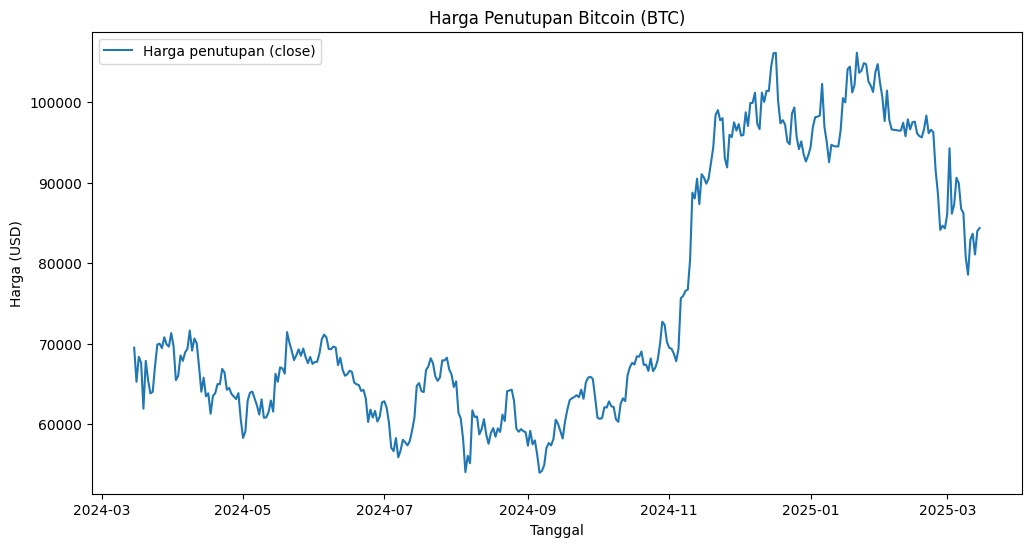

In [14]:
#Visualisasi Harga penutupan
plt.figure(figsize=(12, 6))
plt.plot(crypto_data['close'], label='Harga penutupan (close)')
plt.title('Harga Penutupan Bitcoin (BTC)')
plt.xlabel('Tanggal')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

In [15]:
#rata-rata pergerakan (moving avarage)
crypto_data['MA7'] = crypto_data['close'].rolling(window=7).mean()
crypto_data['MA30'] = crypto_data['close'].rolling(window=30).mean()

#kolom target (7 hari kedepan)
crypto_data['Target'] = crypto_data['close'].shift(-7)

# Hapus baris dengan nilai NaN
crypto_data.dropna(inplace=True)

crypto_data.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,MA7,MA30,Target
time,,,,,,,,,,,
2024-04-13,68422.60,61079.47,67158.30,56915.71,3.689543e+09,64021.36,direct,,68850.112857,68012.581000,64979.21
2024-04-14,65874.88,62229.80,64021.36,40968.04,2.627999e+09,65765.64,direct,,68337.015714,67888.189333,64955.82
2024-04-15,66902.94,62328.07,65765.64,40978.19,2.658417e+09,63447.27,direct,,67168.145714,67827.746667,66854.24
2024-04-16,64385.46,61667.72,63447.27,35542.55,2.234501e+09,63824.70,direct,,66410.320000,67676.421667,66415.06
2024-04-17,64503.77,59682.79,63824.70,41504.19,2.562816e+09,61283.74,direct,,65075.348571,67465.565000,64263.95


In [16]:
# Fitur dan target
X = crypto_data[['close', 'MA7', 'MA30']]
y = crypto_data['Target']

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data Training:", X_train.shape)
print("Data Testing:", X_test.shape)

Data Training: (264, 3)
Data Testing: (66, 3)


In [21]:
# Bangun model Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 4962349.004234265


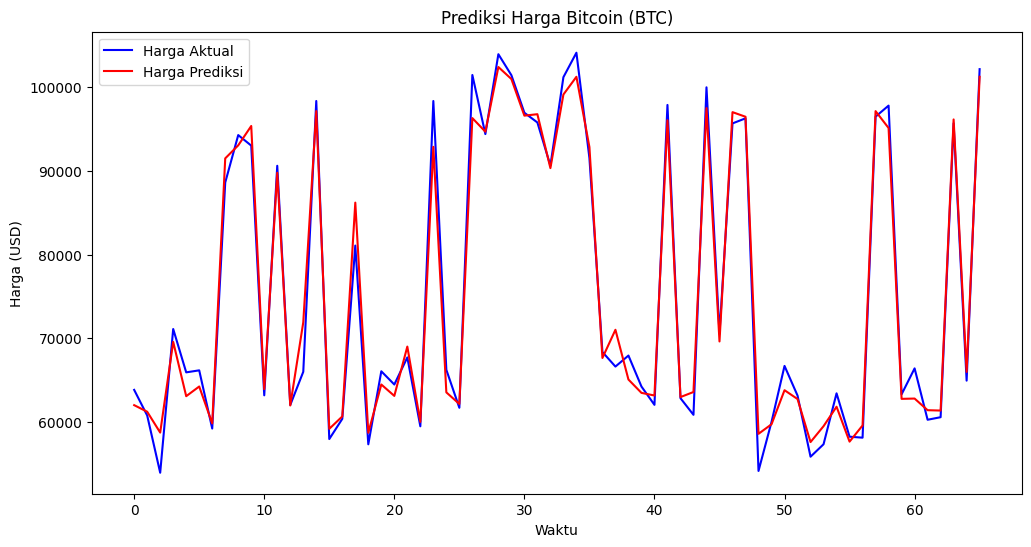

In [18]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Harga Aktual', color='blue')
plt.plot(y_pred, label='Harga Prediksi', color='red')
plt.title('Prediksi Harga Bitcoin (BTC)')
plt.xlabel('Waktu')
plt.ylabel('Harga (USD)')
plt.legend()
plt.show()

In [20]:
# Prediksi 7 hari ke depan
last_data = pd.DataFrame([crypto_data[['close', 'MA7', 'MA30']].iloc[-1].values], 
                         columns=['close', 'MA7', 'MA30'])
future_prices = []

for _ in range(7):
    next_price = model.predict(last_data)[0]
    future_prices.append(next_price)
    # Update data untuk prediksi berikutnya
    last_data = pd.DataFrame([[next_price, last_data['MA7'].values[0], last_data['MA30'].values[0]]], 
                             columns=['close', 'MA7', 'MA30'])

# Tampilkan prediksi
print("Prediksi Harga 7 Hari ke Depan:", future_prices)

Prediksi Harga 7 Hari ke Depan: [np.float64(84159.8560999999), np.float64(85283.72909999998), np.float64(84988.04319999999), np.float64(85410.34109999998), np.float64(84344.34079999995), np.float64(85283.72909999998), np.float64(84988.04319999999)]
